In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from scipy.signal import correlate

In [2]:
# If using Google Colab, mount Google Drive so you can access your Drive folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define path to 'snow_cover_mapping_application/study-sites/'
study_sites_path = 'drive/MyDrive/Research/PhD/snow_cover_mapping/snow_cover_mapping_application/study-sites/'

In [4]:
# Grab list of study site names in folder
os.chdir(study_sites_path)
site_names = sorted([x[0:-1] for x in glob.glob('*/', recursive = True)])
site_names

['Blue',
 'Boulder',
 'Carbon',
 'Coleman',
 'Easton',
 'Emmons',
 'Gulkana',
 'Hidden',
 'Hoh',
 'LemonCreek',
 'RGI60-01.00037',
 'RGI60-01.00038',
 'RGI60-01.00046',
 'RGI60-01.00312',
 'RGI60-01.00566',
 'RGI60-01.00576',
 'RGI60-01.01151',
 'RGI60-01.01390',
 'RGI60-01.01524',
 'RGI60-01.01733',
 'RGI60-01.03861',
 'RGI60-01.04375',
 'RGI60-01.06268',
 'RGI60-01.06722',
 'RGI60-01.08155',
 'RGI60-01.08174',
 'RGI60-01.08246',
 'RGI60-01.08248',
 'RGI60-01.08288',
 'RGI60-01.08296',
 'RGI60-01.08302',
 'RGI60-01.08336',
 'RGI60-01.08353',
 'RGI60-01.08389',
 'RGI60-01.08395',
 'RGI60-01.08403',
 'RGI60-01.08412',
 'RGI60-01.08427',
 'RGI60-01.09148',
 'RGI60-01.09216',
 'RGI60-01.09411',
 'RGI60-01.09639',
 'RGI60-01.10196',
 'RGI60-01.10555',
 'RGI60-01.10689',
 'RGI60-01.10778',
 'RGI60-01.12425',
 'RGI60-01.12635',
 'RGI60-01.13696',
 'RGI60-01.14391',
 'RGI60-01.14443',
 'RGI60-01.14883',
 'RGI60-01.15769',
 'RGI60-01.15788',
 'RGI60-01.16342',
 'RGI60-01.17183',
 'RGI60-01.173

In [28]:
# Define a function for calculating the cross-correlation between PDDs and snowline elevations
def cross_corr(x1, y1, x2, y2):

  # interpolate y1 and y2 onto same x axis
  x = x2
  y1_interp = np.interp(x, x1, y1)

  # remove NaNs
  # inan1 = np.argwhere(np.isnan(y1_interp))
  # inan2 = np.argwhere(np.isnan(y2))
  # ireal = np.argwhere((inan1==False) & (inan2==False))
  # y1_real = y1_interp[ireal]
  # y2_real = y2[ireal]

  # calculate cross-correlation
  xcorr = correlate(y1, y2, mode='same', method='fft')

  return xcorr

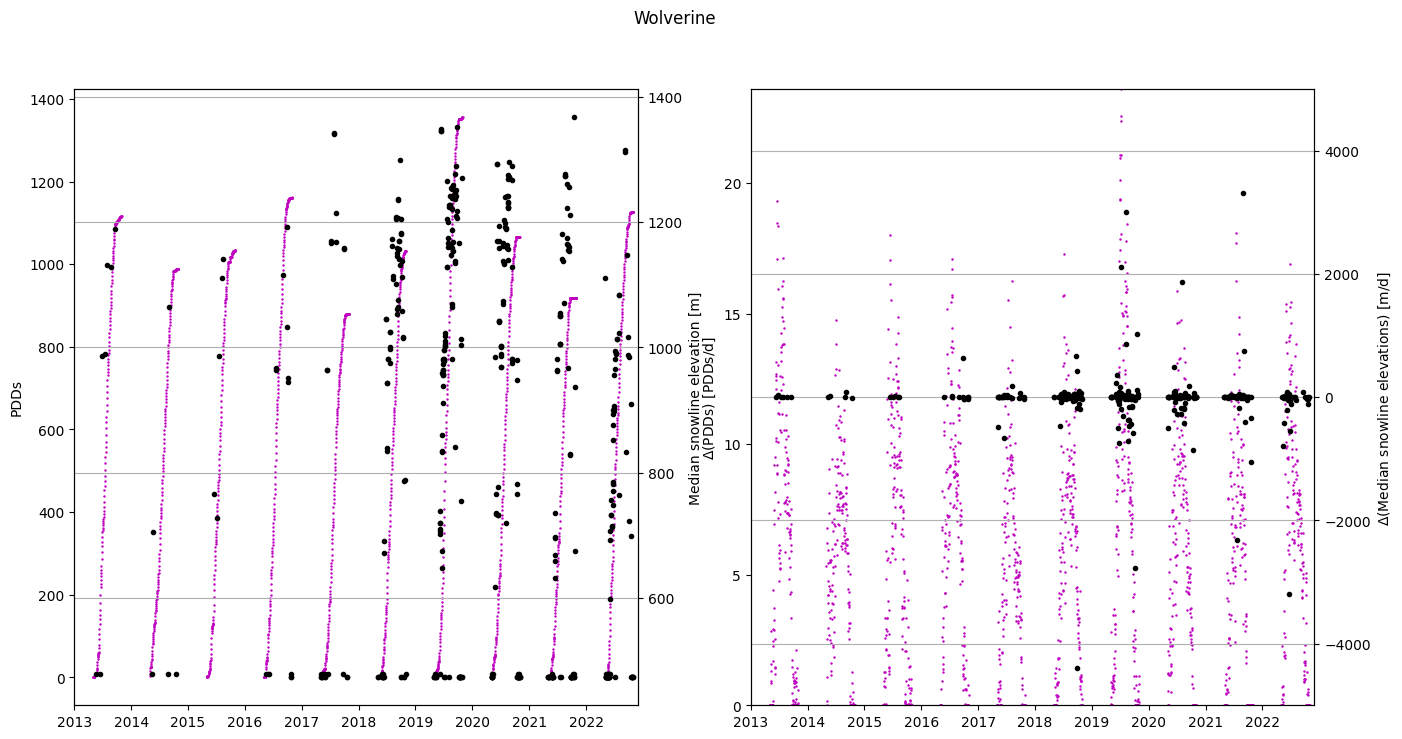

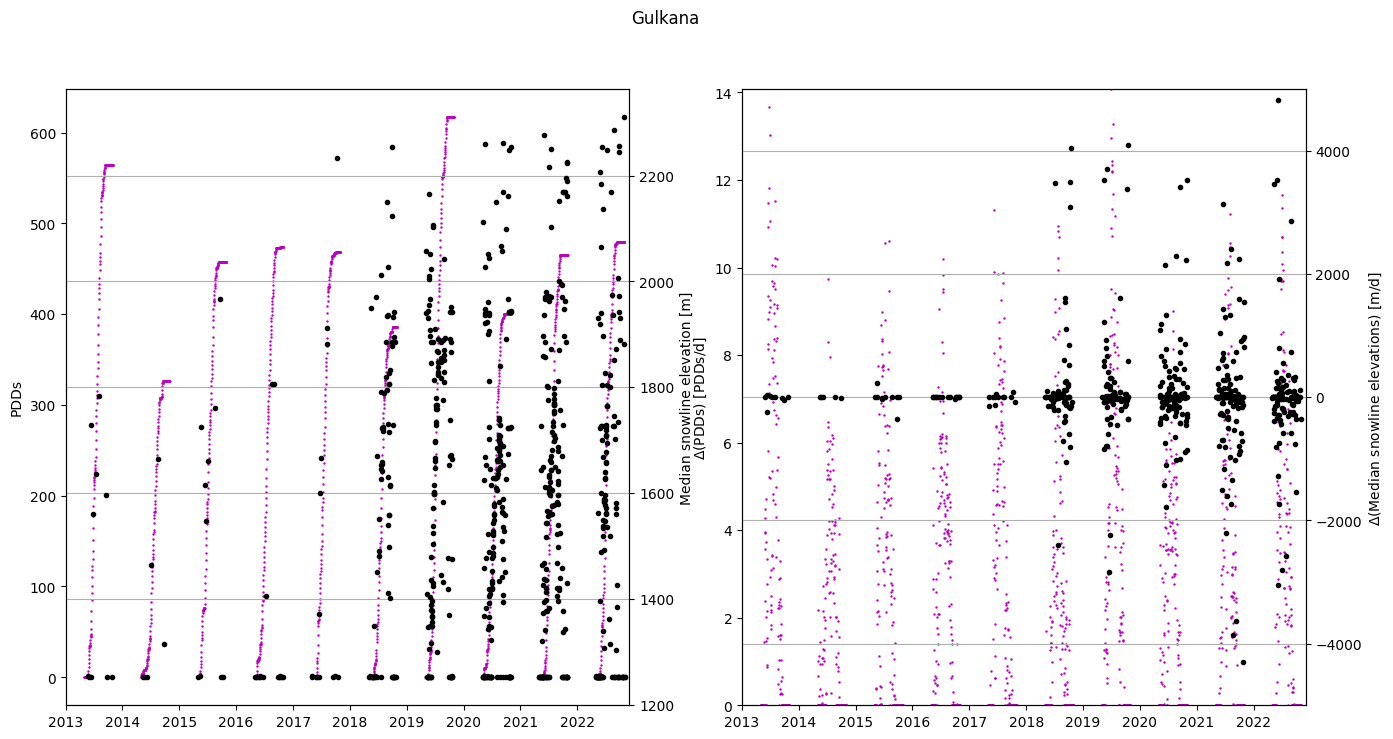

 
No snowlines found for LemonCreek
 


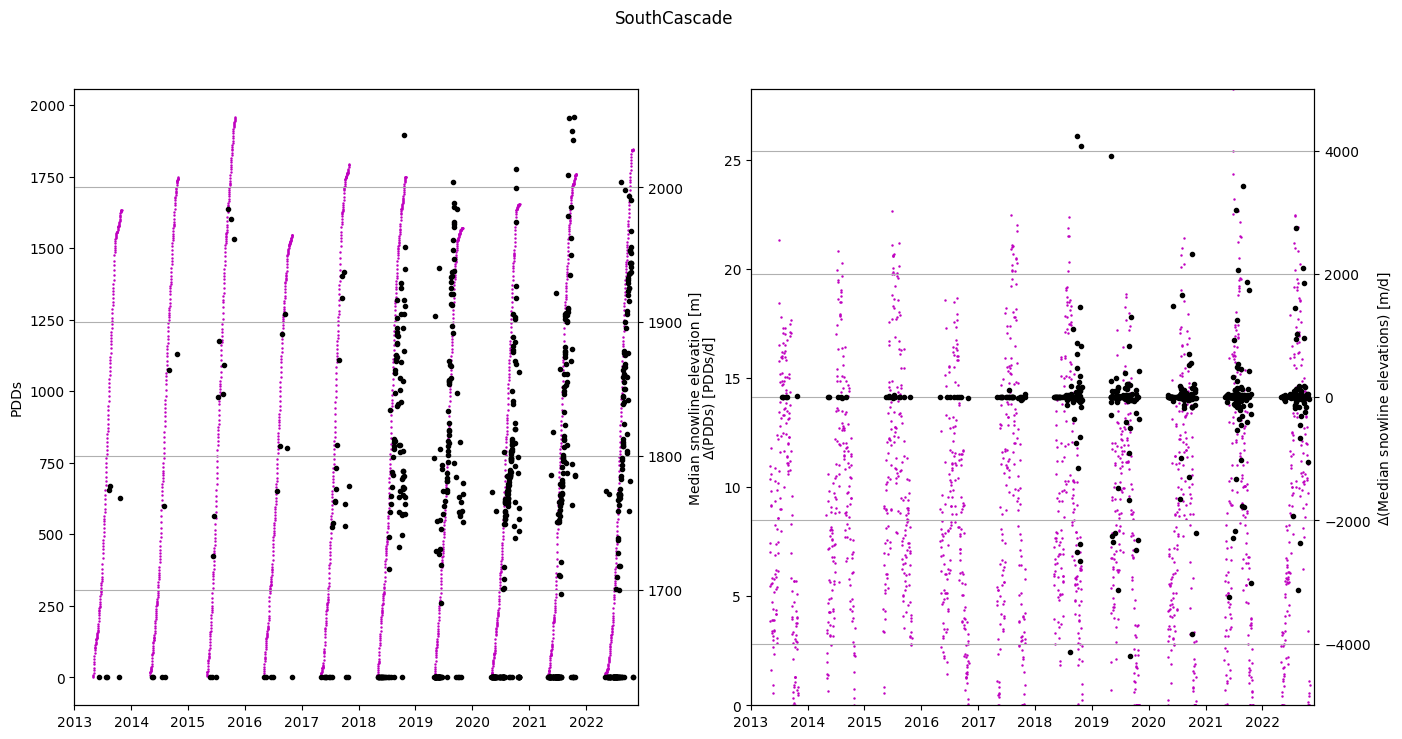

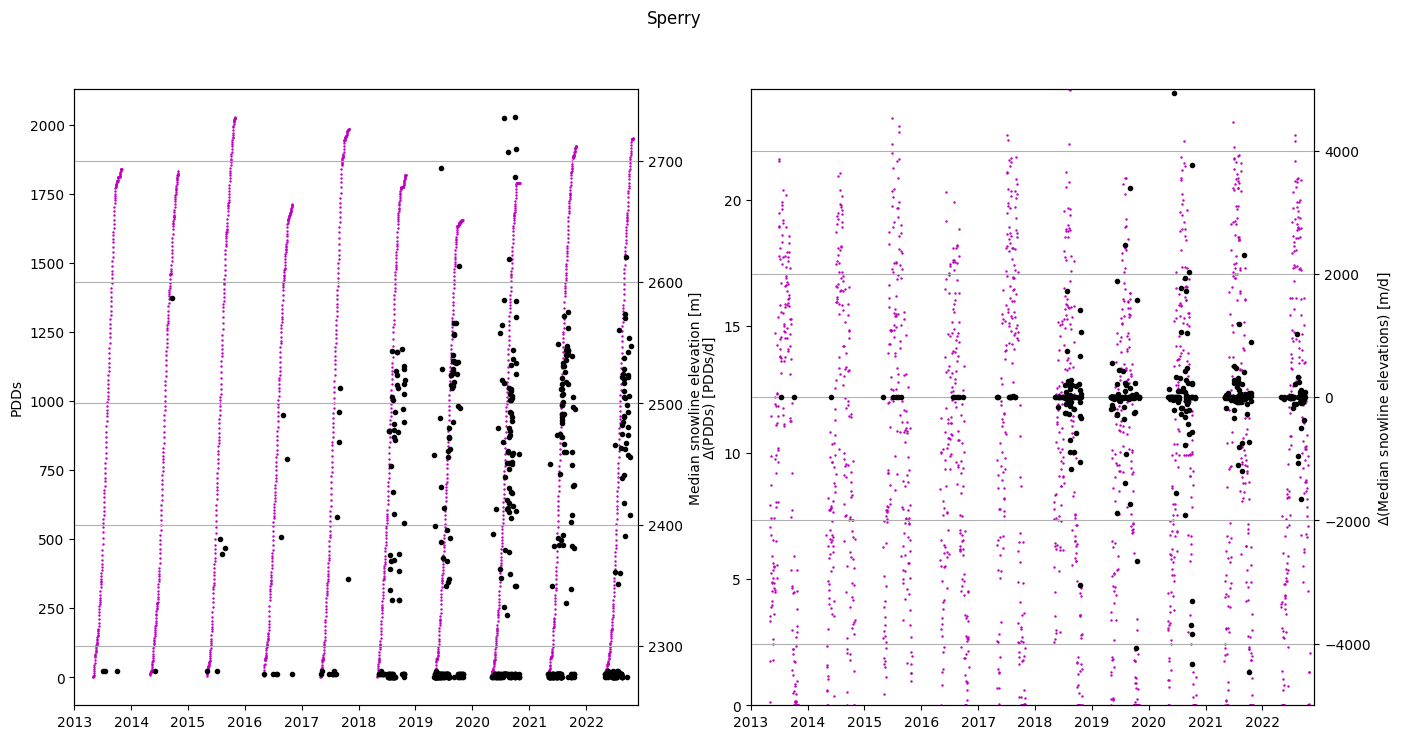

In [5]:
# Define names of study sites to plot
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# loop through study sites
for site_name in site_names:
  # load snowlines
  sl_full = pd.DataFrame()
  sl_fns = glob.glob(site_name + '/imagery/snowlines/*.csv')
  for sl_fn in sl_fns:
    sl = pd.read_csv(sl_fn)
    sl_full = pd.concat([sl_full, sl])
  sl_full.reset_index(drop=True, inplace=True)

  if len(sl_full) > 0:
    sl_full['datetime'] = sl_full['datetime'].astype('datetime64[ns]')
    sl_full = sl_full.sort_values(by='datetime')

    # load ERA data
    ERA_fn = glob.glob(site_name + '/ERA/*.csv')[0]
    ERA = pd.read_csv(ERA_fn)
    ERA['Date'] = ERA['Date'].astype('datetime64[ns]')

    # calculate gradients in snowline elevations and PDDs
    sl_dt = (sl_full['datetime'] - sl_full['datetime'].shift()) / np.timedelta64(1, 'D')
    sl_dz = (sl_full['snowlines_elevs_median_m'] - sl_full['snowlines_elevs_median_m'].shift())
    sl_gradient = sl_dz / sl_dt
    pdd_dt = (ERA['Date'] - ERA['Date'].shift()) / np.timedelta64(1, 'D')
    pdd_dz =  (ERA['PDD'] - ERA['PDD'].shift())
    pdd_gradient = pdd_dz / pdd_dt

    # plot PDDs and snowline elevations
    fig, ax = plt.subplots(1,2, figsize=(16, 8))
    ax[0].plot(ERA['Date'], ERA['PDD'], '.m', markersize=1.5)
    ax[0].set_ylabel('PDDs')
    ax[0].set_xlim([np.datetime64('2013-01-01'), np.datetime64('2022-12-01')])
    ax2 = ax[0].twinx()
    ax2.plot(sl_full['datetime'], sl_full['snowlines_elevs_median_m'], '.k')
    ax2.grid()
    ax2.set_ylabel('Median snowline elevation [m]')
    ax2.set_xlim([np.datetime64('2013-01-01'), np.datetime64('2022-12-01')])

    # plot gradients
    ax[1].plot(ERA['Date'], pdd_gradient, '.m', markersize=1.5)
    ax[1].set_ylabel('$\Delta$(PDDs) [PDDs/d]')
    ax[1].set_xlim([np.datetime64('2013-01-01'), np.datetime64('2022-12-01')])
    ax[1].set_ylim(0, np.nanmax(pdd_gradient))
    ax4 = ax[1].twinx()
    ax4.plot(sl_full['datetime'], sl_gradient, '.k')
    ax4.grid()
    ax4.set_xlim([np.datetime64('2013-01-01'), np.datetime64('2022-12-01')])
    ax4.set_ylabel('$\Delta$(Median snowline elevations) [m/d]')
    ax4.set_ylim(-5000, 5000)

    fig.suptitle(site_name)
    plt.show()

  else:
    print('No snowlines found for ' + site_name)

  print(' ')


In [67]:
# solve for the PDD normalization factor using gradient descent
# adapted from: https://towardsdatascience.com/gradient-descent-in-python-a0d07285742f

def cal_cost(max_value, y1, y2):
  """
  max_value = maximum value over which to normalize y1
  y1 = PDDs
  y2 = median snowline elevations [m]
  """

  # remove NaNs from time series
  ireal = np.argwhere(~np.isnan(y2))
  y1 = y1[ireal]
  y2 = y2[ireal]

  # normalize y1 from 0 to max_value
  y1_norm = ((y1 - np.nanmin(y1)) / (np.nanmax(y1) - np.nanmin(y1))
            * (max_value - np.nanmin(y2)) + np.nanmin(y2))

  # calculate mean difference between y1 and y2
  diff = np.nanmean(np.abs(y1_norm-y2))

  return diff

def gradient_descent(y1, y2, learning_rate=1, iterations=1000):

  cost_history = np.zeros(iterations)
  max_value_history = np.zeros(iterations)
  max_value = np.nanmax(y2)
  for it in range(iterations):

    max_value = max_value - learning_rate
    max_value_history[it] = max_value
    cost_history[it] = cal_cost(max_value, y1, y2)

  # find optimum max_value where cost = minimum
  ibest = np.argwhere(cost_history==np.nanmin(cost_history))[0][0]
  max_value_best = max_value_history[ibest]

  return max_value_best, max_value_history, cost_history


Optimum max value = 2278.0


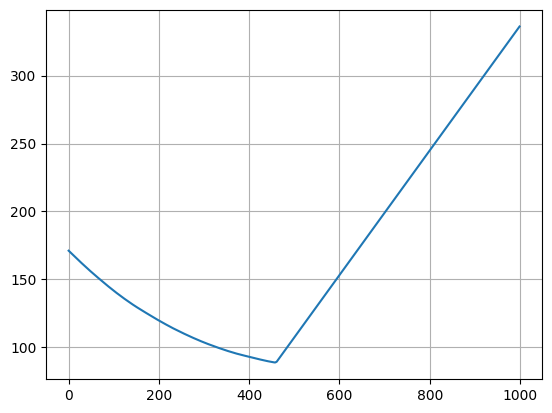

In [68]:
# solve for optimal maximum value for normalization
max_value_best, max_value_history, cost_history = gradient_descent(ERA['PDD'].values, sl_full['snowlines_elevs_median_m'].values)

print('Optimum max value = ' + str(max_value_best))
plt.plot(cost_history)
plt.grid()
plt.show()

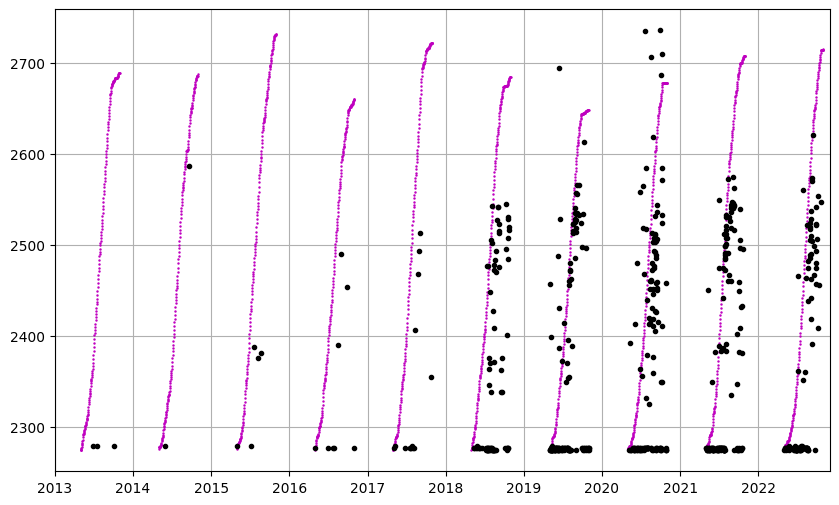

In [70]:
# normalize PDD from min to best max value
PDD = ERA['PDD'].values
PDD_norm = ((PDD - np.nanmin(PDD)) / (np.nanmax(PDD) - np.nanmin(PDD))
            * (np.nanmax(sl_full['snowlines_elevs_median_m'].values) - max_value_best)
            + np.nanmin(sl_full['snowlines_elevs_median_m'].values))

# replot
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(ERA['Date'].values, PDD_norm, '.m', markersize=1.5, label='PDD$_{normalized}$')
ax.plot(sl_full['datetime'], sl_full['snowlines_elevs_median_m'], '.k', label='Median snowline elevations')
ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2022-12-01'))
ax.grid()
# ax.legend(loc='best')
plt.show()

In [29]:
# add days column
sl_full['days'] = (sl_full['datetime'].values - np.datetime64('2010-01-01')) / np.timedelta64(1, 'D')
ERA['days'] = (ERA['Date'].values - np.datetime64('2010-01-01')) / np.timedelta64(1, 'D')
xcorr = cross_corr(sl_full['days'].values, sl_full['snowlines_elevs_median_m'].values,
                   ERA['days'].values, ERA['PDD'].values)

/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:241: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


In [30]:
xcorr

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na